In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
#device_name = tf.test.tpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Found 6310 images belonging to 7 classes.
Found 1819 images belonging to 7 classes.
False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4
False:	block5_pool
{'1000PKR': 0, '100PKR': 1, '10PKR': 2, '20PKR': 3, '5000PKR': 4, '500PKR': 5, '50PKR': 6}
Epoch 1/20
198/197 [==============================] - 142s 715ms/step - loss: 1.8567 - categorical_accuracy: 0.2765 - val_loss: 1.8608 - val_categorical_accuracy: 0.2606
Epoch 2/20
198/197 [==============================] - 134s 679ms/step - loss: 1.5016 - categorical_accuracy: 0.4266 - val_loss: 1.1580 - val_categorical_accuracy: 0.5190
Epoch 3/20
198/197 [==============================] - 1

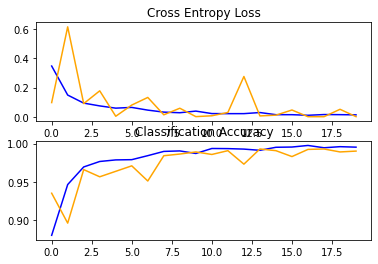

Confusion Matrix
[[256   0   0   0   1   0   3]
 [  0 257   2   0   0   0   1]
 [  0   0 258   1   0   0   0]
 [  0   1   0 259   0   0   0]
 [  0   0   6   1 252   1   0]
 [  0   0   0   0   0 260   0]
 [  1   0   0   0   0   0 259]]
Classification Report
              precision    recall  f1-score   support

     1000PKR       1.00      0.98      0.99       260
      100PKR       1.00      0.99      0.99       260
       10PKR       0.97      1.00      0.98       259
       20PKR       0.99      1.00      0.99       260
     5000PKR       1.00      0.97      0.98       260
      500PKR       1.00      1.00      1.00       260
       50PKR       0.98      1.00      0.99       260

    accuracy                           0.99      1819
   macro avg       0.99      0.99      0.99      1819
weighted avg       0.99      0.99      0.99      1819



In [3]:
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import pyplot

import numpy as np
import PIL

import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, SGD
from keras import activations

from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Model Difinitions
# -------

def set_trainable(model, flag=False):
    for layer in model.layers:
        layer.trainable = flag
        print("{0}:\t{1}".format(layer.trainable, layer.name))

def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]


# Network Architecture 
# Loading pretrained model
pre_model = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet')

# Data augmentation and pre-processing

datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale=1./255)


# Directory setup
train_dir = './drive/My Drive/dataset_google/train'
test_dir = './drive/My Drive/dataset_google/test'

input_shape = pre_model.layers[0].output_shape[1:3]
batch_size = 32
num_of_test_samples = 1819

# Making data generator
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

# Setting epoch size for batch step calculation
epochs = 20

# Steps per epoch setup
steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

# joing directory and filenames
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

# classes available
cls_train = generator_train.classes
cls_test = generator_test.classes

class_names = list(generator_train.class_indices.keys())

num_classes = generator_train.num_classes

# In case of unequal number of dataset, use class weight balancing
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)


# Architecture Definition

# Get last pool/conv layer of pre-trained model
last_conv_block = pre_model.get_layer('block5_pool')
# setup a reference model which as input and conv layer output of pretrained model
ref_model = Model(inputs=pre_model.input, outputs=last_conv_block.output)

# create new model
model = keras.models.Sequential()
# add reference model to it
model.add(ref_model)
# flatten pretrained layers output for dense layer
model.add(Flatten())

# add custom hidden layer
model.add(Dense(1024, activation='relu'))
# Output layer
model.add(Dense(num_classes, activation='softmax'))

# setting learning rate
optimizer = SGD(lr=0.001, momentum=0.9)#Adam(lr=1e-5)
# Loss definition
loss = 'categorical_crossentropy'
# Metrics for measurement
metrics = ['categorical_accuracy']

# for transfer learning set all the layers of pre-trained model to false
set_trainable(ref_model, flag=False)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
labels = generator_train.class_indices
print(labels)

# Begin training for transfer learning
history = model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

# Save Model weights
#model.save('transfer_18.model')
model.save('./drive/My Drive/models/transfer_18.h5')
# Save Model
#model.save_weights('transfer_18_weights.hdf5')

# For finetune set all the layers of pre-trained model to true
set_trainable(ref_model, True)

# Optimize learning rate 
optimizer_fine = SGD(lr=0.0001, momentum=0.9)#Adam(lr=1e-7)
# Compile the model
model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

# Train again for fine tuning
history = model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)
# Save Model
#model.save('finetune_18.model')
model.save('./drive/My Drive/models/finetune_18.h5')
# Save weights
#model.save_weights('finetune_18_weights.hdf5')
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['categorical_accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_categorical_accuracy'], color='orange', label='test')
# save plot to file
filename = sys.argv[0].split('/')[-1]
pyplot.savefig(filename + 'plot.png')
pyplot.show()
#pyplot.close()
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(generator_test, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(generator_test.classes, y_pred))
print('Classification Report')
target_names = ['1000PKR','100PKR', '10PKR', '20PKR','5000PKR' ,'500PKR', '50PKR']
print(classification_report(generator_test.classes, y_pred, target_names=target_names))

In [0]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from numpy import argmax 
import numpy as np


# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	return img

# load an image and predict the class
def run():
	# load the image
	for i in range(245,254):
		img = load_image('./drive/My Drive/dataset_google/validate/50PKR/50PKR.'+str(i)+'.jpg')
		# load model
		model = load_model('./drive/My Drive/models/finetune_5.h5')
		# predict the class
		result = argmax(model.predict(img)[0])
		predicted_probabilities = model.predict(img)
		#actual_results = model.predict(img)
		print(str(i) + '...Predict class {}'.format(result))
		print(np.round(predicted_probabilities*100,2))
		#print(actual_results)
		# entry point, run the example
run()

245...Predict class 4
[[  0.   0.   0.   0. 100.]]
246...Predict class 4
[[  0.   0.   0.   0. 100.]]
247...Predict class 4
[[  0.   0.   0.   0. 100.]]
248...Predict class 4
[[  0.   0.   0.   0. 100.]]
249...Predict class 4
[[  0.   0.   0.   0. 100.]]
250...Predict class 4
[[  0.   0.   0.   0. 100.]]
251...Predict class 4
[[  0.   0.   0.   0. 100.]]
252...Predict class 4
[[  0.   0.   0.   0. 100.]]
253...Predict class 4
[[  0.   0.   0.   0. 100.]]
